## Transfered Learning Cats vs Dogs

Used pretrained RESNET34 and finetune the convet.   
The final fully connected layers are reset and retrained with our training set.

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

%matplotlib inline

### Load and view data

In [5]:
PATH = "dog_cat_small/"

In [6]:
os.listdir(PATH)

['.DS_Store', 'train', 'valid']

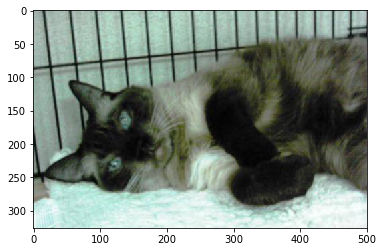

In [7]:
files = os.listdir(f'{PATH}valid/cats')[:5]
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
image_datasets = {x: datasets.ImageFolder(os.path.join(PATH, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
batch_size = 4

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

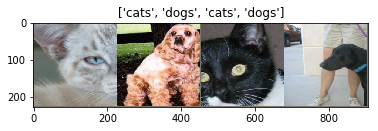

In [10]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

### Define model train and validation accuracy/loss

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        model.train()
        scheduler.step()
        
        total = 0
        sum_loss = 0.0
        correct = 0
        
        # Iterate over data.
        for data in dataloaders['train']:
            inputs, labels = data
            batch = inputs.shape[0]
            if use_gpu:
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

         # statistics
            total += batch
            sum_loss += batch * loss.data[0]
            correct += torch.sum(preds == labels.data)
            
        epoch_loss_train = sum_loss / total
        epoch_acc_train = 100 * correct / total
            
        epoch_acc_val, epoch_loss_val = model_accuracy_loss(model, dataloaders['valid'])
            
        print('Train Loss: {:.4f} Acc: {:.2f}'.format(epoch_loss_train, epoch_acc_train))
        print('Valid Loss: {:.4f} Acc: {:.2f}'.format(epoch_loss_val, epoch_acc_val))

        # deep copy the model
        if epoch_acc_val > best_acc:
            best_acc = epoch_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())

    print('-' * 10)
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
def model_accuracy_loss(model, val_loader):
    model.eval()
    correct = 0
    sum_loss = 0.0
    total = 0
    for data in val_loader:
        inputs, labels = data
        batch = inputs.shape[0]
        if use_gpu:
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        outputs = model(inputs)
        _,preds = torch.max(outputs.data,1)
        loss = criterion(outputs,labels)
        sum_loss += batch * loss.data[0]
        total += batch
        correct += torch.sum(preds == labels.data)
    return 100*correct/total, sum_loss/total

### Load pretrained resnet34 and reset final fully connected layer

In [16]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# All parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

Epoch 0/14
Train Loss: 0.7277 Acc: 0.7188
Valid Loss: 0.1444 Acc: 94.0000
Epoch 1/14
Train Loss: 0.6370 Acc: 0.7903
Valid Loss: 0.1161 Acc: 94.0000
Epoch 2/14
Train Loss: 0.5453 Acc: 0.8020
Valid Loss: 0.1832 Acc: 94.0000
Epoch 3/14
Train Loss: 0.5934 Acc: 0.7754
Valid Loss: 0.1236 Acc: 97.3333
Epoch 4/14
Train Loss: 0.4179 Acc: 0.8469
Valid Loss: 0.0766 Acc: 97.3333
Epoch 5/14
Train Loss: 0.4701 Acc: 0.8070
Valid Loss: 0.1492 Acc: 94.0000
Epoch 6/14
Train Loss: 0.3047 Acc: 0.8636
Valid Loss: 0.1350 Acc: 96.6667
Epoch 7/14
Train Loss: 0.2925 Acc: 0.8669
Valid Loss: 0.0964 Acc: 97.3333
Epoch 8/14
Train Loss: 0.2509 Acc: 0.9018
Valid Loss: 0.0762 Acc: 98.0000
Epoch 9/14
Train Loss: 0.2453 Acc: 0.8985
Valid Loss: 0.0742 Acc: 97.3333
Epoch 10/14
Train Loss: 0.2015 Acc: 0.9334
Valid Loss: 0.0660 Acc: 98.6667
Epoch 11/14
Train Loss: 0.2371 Acc: 0.9002
Valid Loss: 0.0578 Acc: 97.3333
Epoch 12/14
Train Loss: 0.2088 Acc: 0.9085
Valid Loss: 0.0436 Acc: 99.3333
Epoch 13/14
Train Loss: 0.2219 Acc:

### Visualize predictions

In [28]:
def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for data in dataloaders['valid']:
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return 

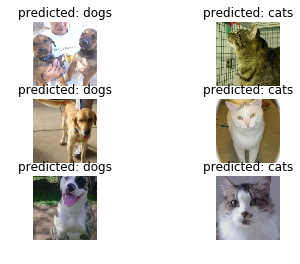

In [29]:
visualize_model(model_ft)